# ModelBox SDK Tutorial with Pytorch
This notebook demonstrates the use of the ModelBox Python SDK with PyTorch and explains the major concepts around working with models and checkpoints.
We will train the MNIST classifier, and use ModelBox to store the checkpoints during training and also store the final model which is meant to be deployed in production.

## Install ModelBox SDK

In [11]:
pip install modelbox==0.0.5

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 44.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time

# Import the ModelBox Client and initialize it
from modelbox.modelbox import ModelBox, MLFramework, Artifact, ArtifactMime, MetricValue, Event, EventSource
mbox = ModelBox(addr="172.21.0.2:8085") # Address could be in env var as well MODELBOX_API_ADDR

In [3]:
experiment = mbox.new_experiment(name="cifar10", owner="diptanuc@gmail.com", namespace="modelbox-demos", external_id="", framework=MLFramework.PYTORCH)

In [4]:
data_dir = "data/CIFAR10"
compressed_ds = "./data/CIFAR10/cifar-10-python.tar.gz"
data_tfms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
}

params = {
    "lr": 1e-2,
    "bs": 128,
    "input_sz": 32 * 32 * 3,
    "n_classes": 10,
    "model_filename": "basemodel",
}
# Step 2: Log config & pararameters
experiment.update_metadata(key="dataset/path", value=data_dir)
experiment.update_metadata(key='hyperparmas', value=params)
# TODO Log the data transformations - support tranforming python objects to class name as strings and their args as values

UpdateMetadataResponse(updated_at=seconds: 1665545101
nanos: 698638074
)

In [5]:
# Model & Dataset
class BaseModel(nn.Module):
    def __init__(self, input_sz, hidden_dim, n_classes):
        super(BaseModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_sz, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_classes),
        )

    def forward(self, input):
        x = input.view(-1, 32 * 32 * 3)
        return self.main(x)

In [6]:
experiment.log_event(Event(name="data_download_start", source=EventSource(name="trainer"), wallclock_time = int(time.time()) , metadata={}))
trainset = datasets.CIFAR10(data_dir, transform=data_tfms["train"], download=True)
experiment.log_event(Event(name="data_download_finish", source=EventSource(name="trainer"), wallclock_time = int(time.time()) , metadata={}))
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=params["bs"], shuffle=True
)
dataset_size = {"train": len(trainset)}
# Log the dataset size
experiment.update_metadata(key="dataset/size", value=dataset_size)


# Instatiate model, criterion and optimizer
model = BaseModel(params["input_sz"], params["input_sz"], params["n_classes"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=params["lr"])

Files already downloaded and verified


In [7]:
for i, (x, y) in enumerate(trainloader, 0):
    optimizer.zero_grad()
    outputs = model.forward(x)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, y)
    acc = (torch.sum(preds == y.data)) / len(x)
    experiment.log_metrics(metrics={'loss': loss, 'accu': acc}, step=i, wallclock=int(time.time()))
    loss.backward()
    optimizer.step()

In [8]:
from modelbox.notebook_widgets import ExperimentDisplay
ed = ExperimentDisplay(experiment)
ed.info()

| Experiment    |                                          |
|---------------|------------------------------------------|
| id            | 92b451da8f036dd4492c5ef1f27049c84687abc4 |
| name          | cifar10                                  |
| owner         | diptanuc@gmail.com                       |
| namespace     | modelbox-demos                           |
| creation time | seconds: 1665545101                      |
| updated time  | seconds: 1665545101                      |
##### Metadata
|              |                                                                                                 |
|--------------|-------------------------------------------------------------------------------------------------|
| hyperparmas  | {'bs': 128.0, 'input_sz': 3072.0, 'n_classes': 10.0, 'model_filename': 'basemodel', 'lr': 0.01} |
| dataset/path | data/CIFAR10                                                                                    |
| dataset/size | {'train': 50000.0}                                                                              |

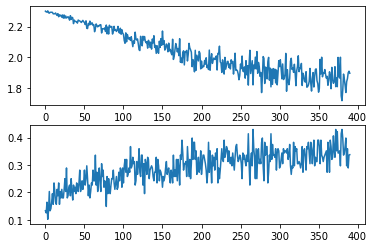

In [9]:
ed.metrics()

In [10]:
ed.events()

| wallclock           | event                | source   |
|---------------------|----------------------|----------|
| seconds: 1665545105 | data_download_start  | trainer  |
| seconds: 1665545106 | data_download_finish | trainer  |